<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='left' width='50%'/>
<br><br><br><br>

### Mini-Project: Investigating summer OLCI radiance and reflectance spectra over upwelling thermal fronts in the EBUS system of central southern.
Claudio Iturra, 2024

In [1]:
# import libraries
import datetime                           # a lirbary that supports the creation of date objects
import os                                 # a library that allows us access to basic operating system commands like making directories
from pathlib import Path                  # a library that helps construct system path objects
import shutil                             # a library that allows us access to basic operating system commands like copy
import eumdac                             # a tool that helps us download via the eumetsat/data-store
import xarray as xr                       # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt           # a library that support plotting
import numpy as np                        # a library that provides support for array-based mathematics
import eumartools                         # a EUMETSAT library that support working with Sentinel-3 products
import glob
import cartopy
import cartopy.crs as ccrs                # a library that supports mapping
import matplotlib.ticker as mticker       # a library that extends plotting support
import zipfile                            # a library that allows us to unzip zip-files.

In [2]:
# make a download directory
download_dir = os.path.join(os.getcwd(), "001T")
os.makedirs(download_dir, exist_ok=True)

In [3]:
# load credentials
credentials_file = os.path.join(os.path.expanduser("~"),'.eumdac','credentials')
credentials = Path(credentials_file).read_text().split(',')
token = eumdac.AccessToken((credentials[0], credentials[1]))
print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '430fe1cf-ed7e-3e26-82a9-02b5b6023f27' expires 2024-03-20 21:27:03.275131


In [4]:
# time filter the collection for products
start = datetime.datetime(2024, 1, 8, 0, 0)
end = datetime.datetime(2024, 1, 8, 23, 59)

In [5]:
# spatial filtering
lonmin = -74.44
lonmax = -72.17
latmin = -37.79
latmax = -35.3
roi = [[lonmin, latmin], [lonmin, latmax], [lonmax, latmax], [lonmax, latmin], [lonmin, latmin]]

In [6]:
# choose collection
collectionID = 'EO:EUM:DAT:0407'
selected_collection = datastore.get_collection(collectionID)

In [7]:
products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end,
    timeliness='NT')

In [8]:
for product in products:
    print(product)

S3A_OL_2_WFR____20240108T143630_20240108T143930_20240109T215118_0179_107_324_3600_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20240108T135730_20240108T140030_20240109T195850_0180_088_181_3600_MAR_O_NT_003.SEN3


In [14]:
# getting a single component(s); chl, geo locations and flags

test_list = ["chl_nn.nc", "geo_coordinates.nc", "wqsf.nc"]

for product in products:
    print(f"Getting {product}")
    product_download_directory = os.path.join(download_dir, str(product))
    os.makedirs(product_download_directory, exist_ok=True)
    for entry in product.entries:
        res = [ele for ele in test_list if(ele == os.path.basename(entry))]
        if res:
            with product.open(entry=entry) as fsrc, open(os.path.join(product_download_directory, fsrc.name),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')

Getting S3A_OL_2_WFR____20240108T143630_20240108T143930_20240109T215118_0179_107_324_3600_MAR_O_NT_003.SEN3
Download of file wqsf.nc finished.
Download of file geo_coordinates.nc finished.
Download of file chl_nn.nc finished.
Getting S3B_OL_2_WFR____20240108T135730_20240108T140030_20240109T195850_0180_088_181_3600_MAR_O_NT_003.SEN3
Download of file chl_nn.nc finished.
Download of file geo_coordinates.nc finished.
Download of file wqsf.nc finished.


In [9]:
# adapting to SST
collectionID = 'EO:EUM:DAT:0412'
selected_collection = datastore.get_collection(collectionID)

products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end,
    timeliness='NT')

In [10]:
for product in products:
    print(product)

S3A_SL_2_WST____20240108T131113_20240108T145212_20240109T203155_6059_107_323______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20240108T123212_20240108T141312_20240109T183706_6059_088_180______MAR_O_NT_003.SEN3
S3A_SL_2_WST____20240108T030518_20240108T044617_20240109T085901_6059_107_317______MAR_O_NT_003.SEN3


In [18]:
# getting an entire product
for product in products:
    # this gets our files....
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {fdst.name} finished.')

    os.remove(fdst.name)

Download of product S3A_SL_2_WST____20240108T131113_20240108T145212_20240109T203155_6059_107_323______MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Volumes/SanDisk/Python/Eumetsat/SMA/learn-olci/2_OLCI_advanced/001T/S3A_SL_2_WST____20240108T131113_20240108T145212_20240109T203155_6059_107_323______MAR_O_NT_003.SEN3.zip finished.
Download of product S3B_SL_2_WST____20240108T123212_20240108T141312_20240109T183706_6059_088_180______MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Volumes/SanDisk/Python/Eumetsat/SMA/learn-olci/2_OLCI_advanced/001T/S3B_SL_2_WST____20240108T123212_20240108T141312_20240109T183706_6059_088_180______MAR_O_NT_003.SEN3.zip finished.
Download of product S3A_SL_2_WST____20240108T030518_20240108T044617_20240109T085901_6059_107_317______MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Volumes/SanDisk/Python/Eumetsat/SMA/learn-olci/2_OLCI_advanced/001T/S3A_SL_2_WST____20240108T030518_20240108T044617_20240109T085901_6059_107_317______MAR_O_NT_003.SEN3.

FIGURE

In [9]:
# select downloaded product
product_dir = os.path.join(download_dir, "S3B_OL_2_WFR____20240108T135730_20240108T140030_20240109T195850_0180_088_181_3600_MAR_O_NT_003.SEN3")
input_products = glob.glob(os.path.join(product_dir, "*.nc"))

In [10]:
# open the components in one go with xarray
ds_CHL = xr.open_mfdataset(input_products)

In [11]:
ds_CHL

<xarray.Dataset> Size: 716MB
Dimensions:     (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    CHL_NN      (rows, columns) float32 80MB dask.array<chunksize=(1364, 1622), meta=np.ndarray>
    CHL_NN_err  (rows, columns) float32 80MB dask.array<chunksize=(1364, 1622), meta=np.ndarray>
    WQSF        (rows, columns) uint64 159MB dask.array<chunksize=(585, 695), meta=np.ndarray>
    altitude    (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    latitude    (rows, columns) float64 159MB dask.array<chunksize=(818, 973), meta=np.ndarray>
    longitude   (rows, columns) float64 159MB dask.array<chunksize=(818, 973), meta=np.ndarray>
Attributes: (12/17)
    absolute_orbit_number:  29713
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2024-01-09T19:58:50Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.02
    start_time:             2024-01-08T13:57:29.691978Z
    stop_time:              2024-01-08T14:00:29.615852Z
    title:                  OLCI Level 2 WATER Product, Neural Net Chlorophyl...

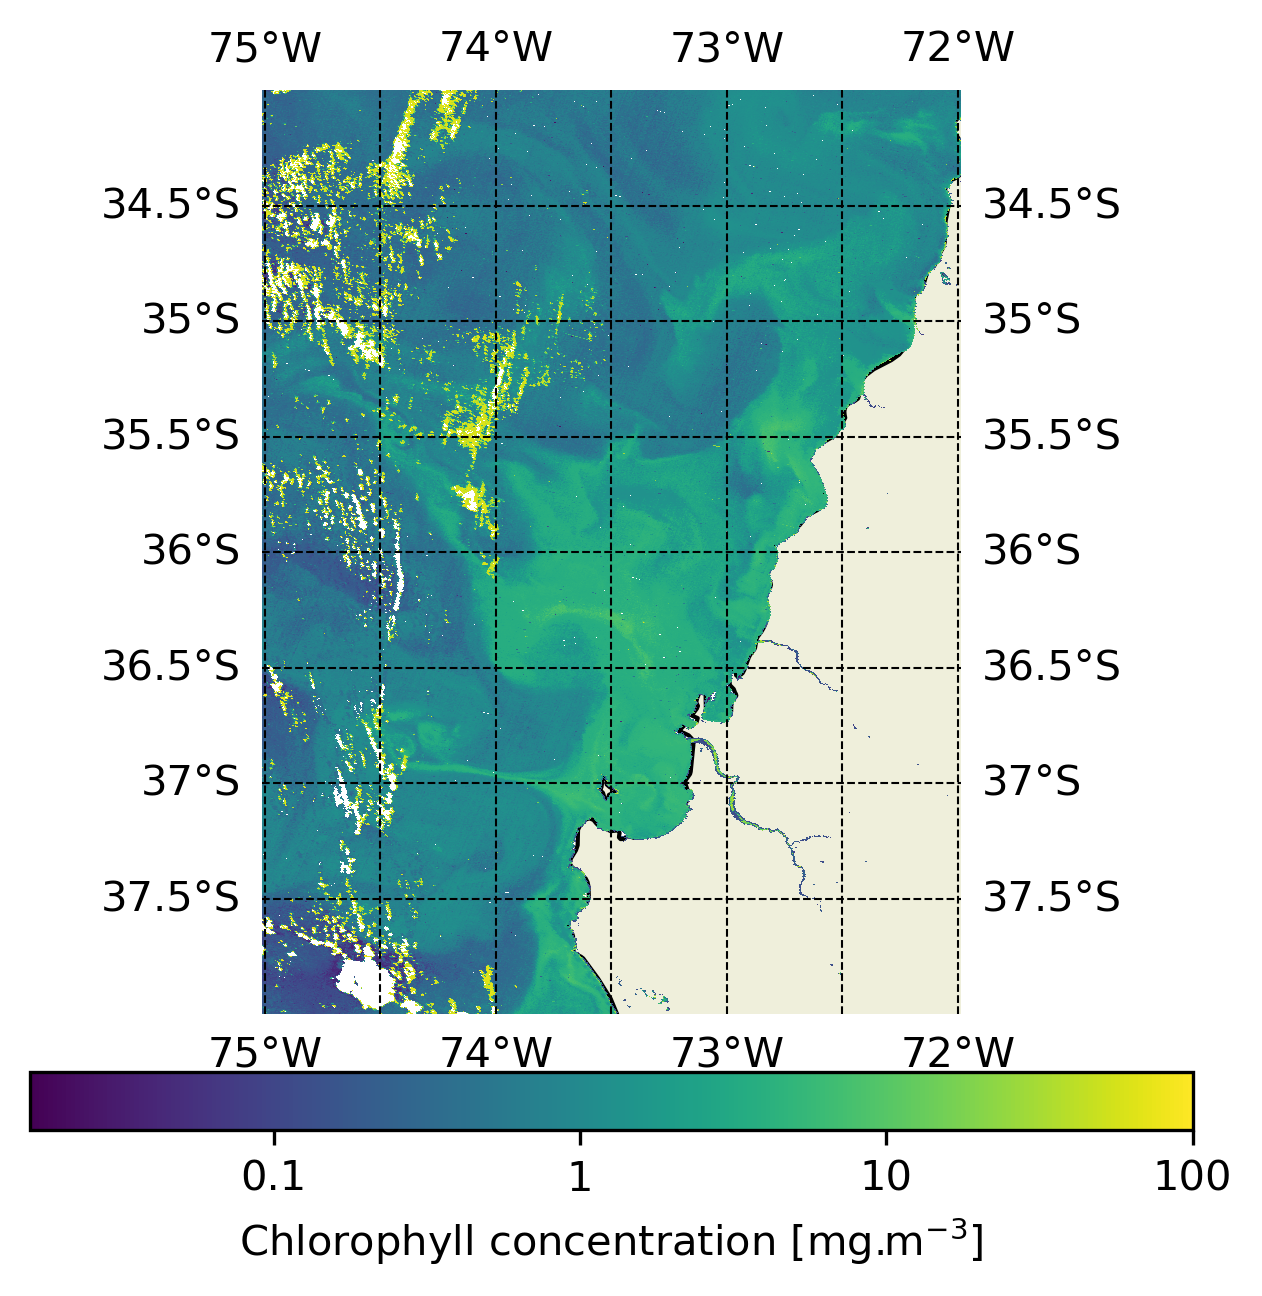

In [12]:
# make a figure
fig, m = plt.subplots(1, 1, figsize=(5,5), dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})

# make a plot
p1 = m.pcolormesh(ds_CHL.longitude, ds_CHL.latitude, ds_CHL.CHL_NN, transform=ccrs.PlateCarree(), cmap="viridis")

# add coast/land layer (not from our data!)
m.add_feature(cartopy.feature.LAND, edgecolor='black')

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
m.axis('off')

# colorbar
cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
ticks = [-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')
plt.xlim([ -75.0140 ,-71.9877])
plt.ylim([ -38 ,-34])

# show it!
plt.show()

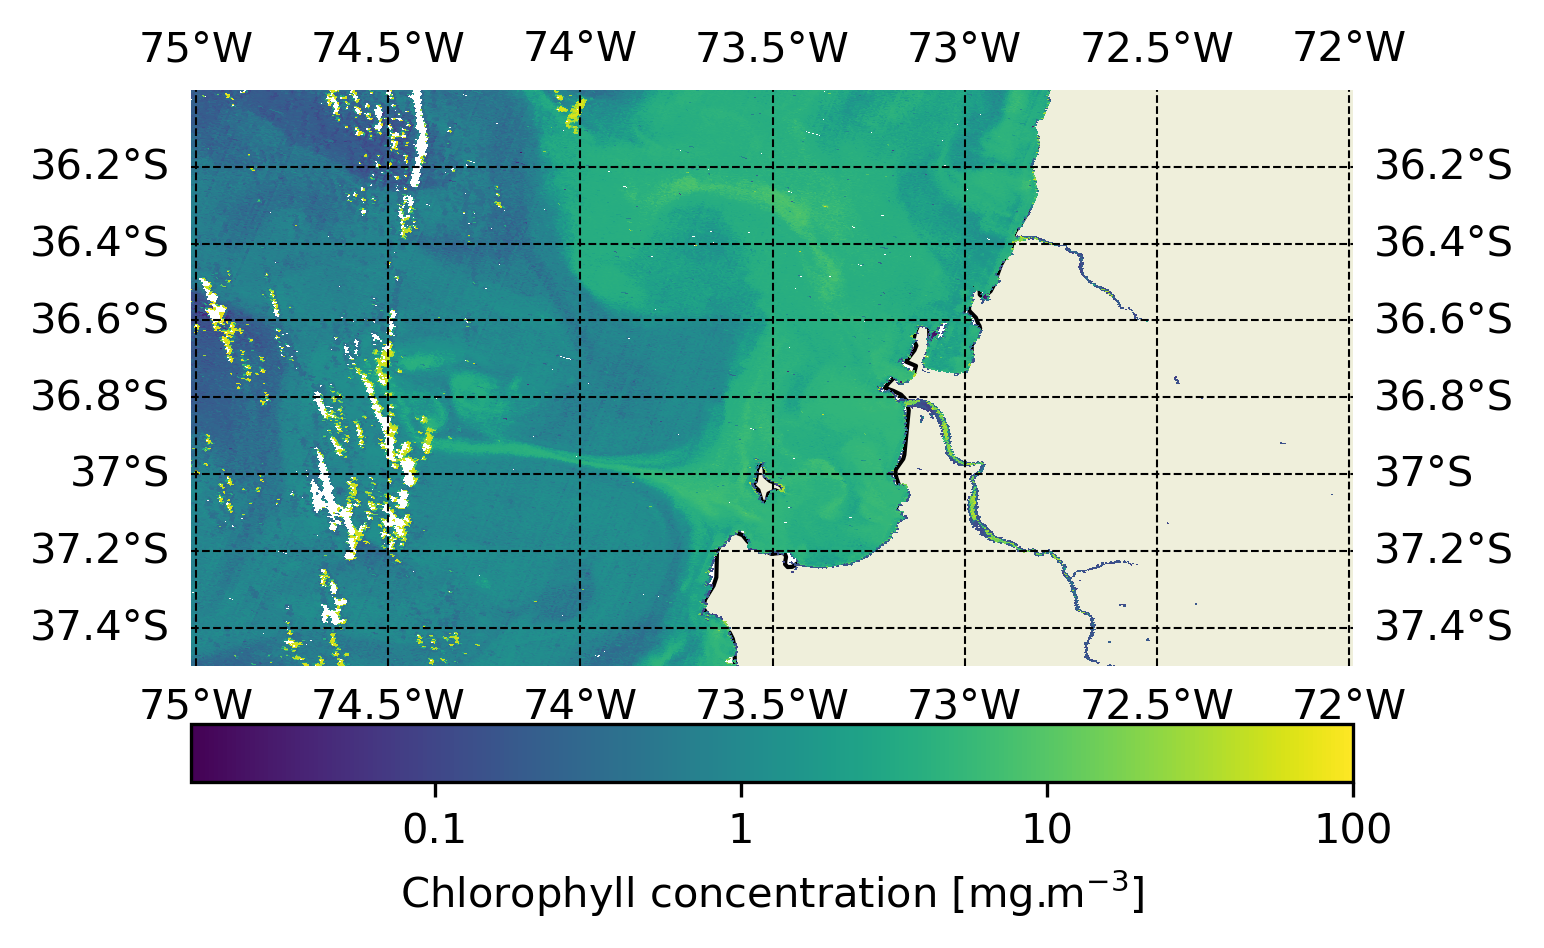

In [27]:
# make a figure
fig, m = plt.subplots(1, 1, figsize=(5,5), dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})

# make a plot
p1 = m.pcolormesh(ds_CHL.longitude, ds_CHL.latitude, ds_CHL.CHL_NN, transform=ccrs.PlateCarree(), cmap="viridis")

# add coast/land layer (not from our data!)
m.add_feature(cartopy.feature.LAND, edgecolor='black')

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
m.axis('off')

# colorbar
cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
ticks = [-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')
plt.xlim([ -75.0140 ,-71.9877])
plt.ylim([ -37.5 ,-36])

# show it!
plt.show()

SST

In [16]:
product_dir = os.path.join(download_dir, "S3A_SL_2_WST____20240108T030518_20240108T044617_20240109T085901_6059_107_317______MAR_O_NT_003.SEN3")
input_products = glob.glob(os.path.join(product_dir, "*.nc"))

In [17]:
# open the components in one go with xarray
ds_SST = xr.open_mfdataset(input_products)
ds_SST

<xarray.Dataset> Size: 7GB
Dimensions:                            (time: 1, nj: 40395, ni: 1500, channel: 3)
Coordinates:
    lat                                (nj, ni) float32 242MB dask.array<chunksize=(5050, 188), meta=np.ndarray>
    lon                                (nj, ni) float32 242MB dask.array<chunksize=(5050, 188), meta=np.ndarray>
  * time                               (time) datetime64[ns] 8B 2024-01-08T03...
Dimensions without coordinates: nj, ni, channel
Data variables: (12/22)
    adi_dtime_from_sst                 (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    aerosol_dynamic_indicator          (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    brightness_temperature             (channel, time, nj, ni) float32 727MB dask.array<chunksize=(1, 1, 10099, 375), meta=np.ndarray>
    dt_analysis                        (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    dual_nadir_sst_difference          (time, nj, ni) float32 242MB dask.array<chunksize=(1, 10099, 375), meta=np.ndarray>
    l2p_flags                          (time, nj, ni) int16 121MB dask.array<chunksize=(1, 10099, 375), meta=np.ndarray>
    ...                                 ...
    sses_standard_deviation            (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    sst_algorithm_type                 (time, nj, ni) int8 61MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    sst_dtime                          (time, nj, ni) timedelta64[ns] 485MB dask.array<chunksize=(1, 10099, 375), meta=np.ndarray>
    sst_theoretical_uncertainty        (time, nj, ni) float32 242MB dask.array<chunksize=(1, 10099, 375), meta=np.ndarray>
    wind_speed                         (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
    wind_speed_dtime_from_sst          (time, nj, ni) float32 242MB dask.array<chunksize=(1, 13465, 500), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    acknowledgment:             European Commission Copernicus Programme
    cdm_data_type:              swath
    comment:                    GHRSST SST L2P
    creator_email:              ops@eumetsat.int
    ...                         ...
    summary:                    Sentinel-3A SLSTR skin sea surface temperature
    time_coverage_end:          20240108T044616Z
    time_coverage_start:        20240108T030517Z
    title:                      Sentinel-3A SLSTR L2P SST dataset
    uuid:                       TBC
    westernmost_longitude:      -174.81423950195312

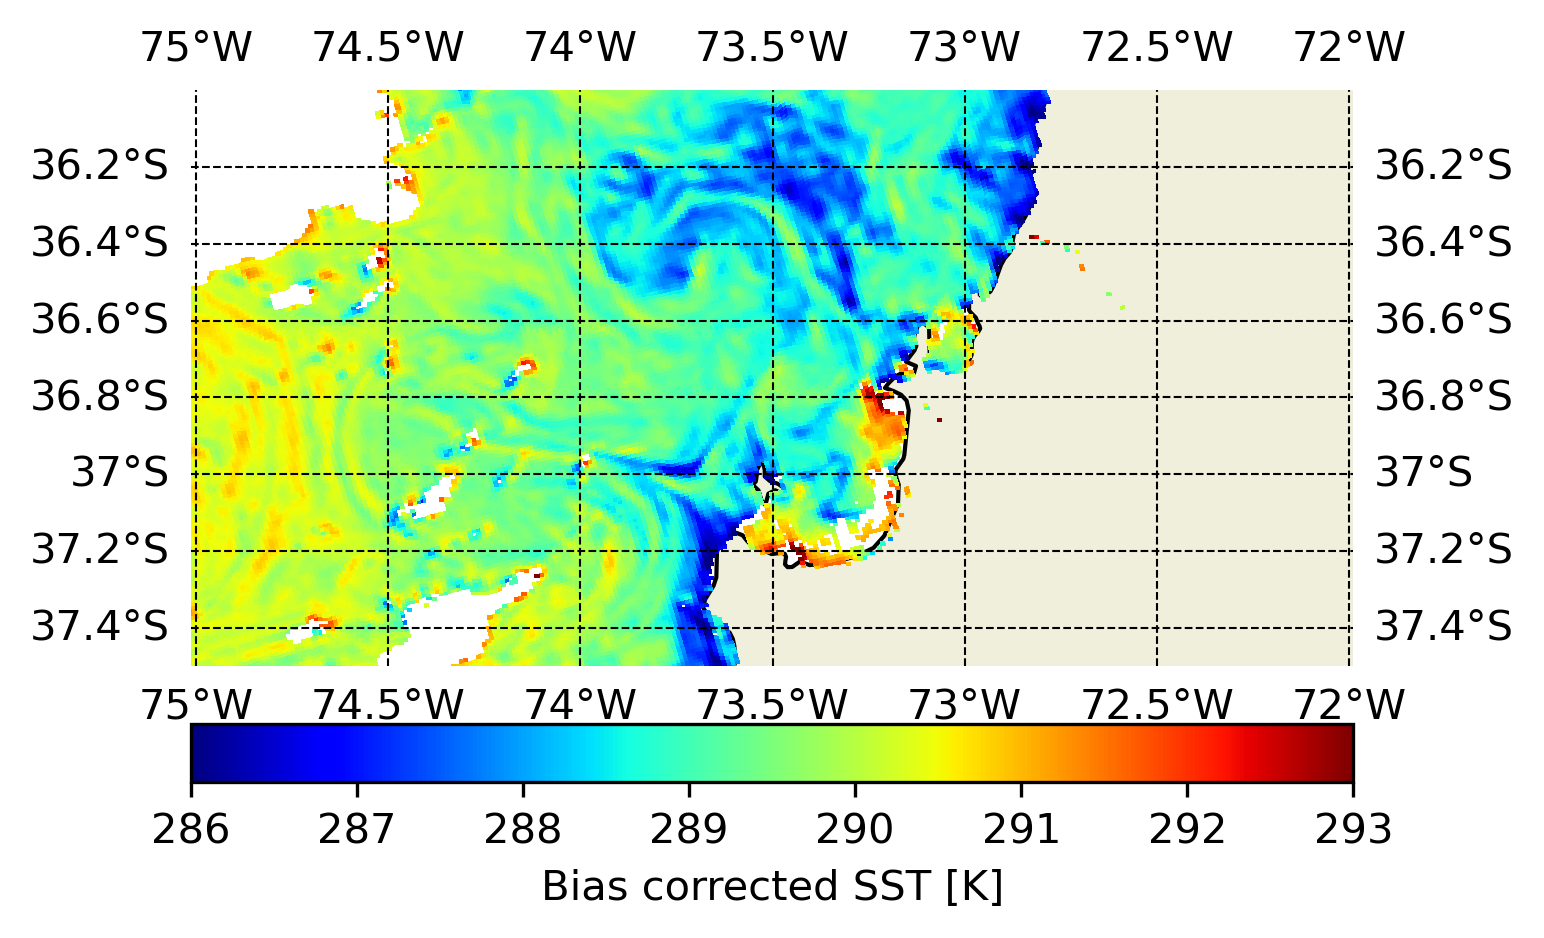

In [21]:
# make a figure
fig, m = plt.subplots(1, 1, figsize=(5, 5), dpi=300, subplot_kw={"projection": ccrs.PlateCarree()})

# make a plot
p1 = m.pcolormesh(ds_SST.lon, ds_SST.lat, np.squeeze(ds_SST.sea_surface_temperature + ds_SST.sses_bias),vmin=286,vmax=293,
                  transform=ccrs.PlateCarree(), cmap="jet")

# add coast/land layer (not from our data!)
m.add_feature(cartopy.feature.LAND, edgecolor='black')

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
m.axis('off')

# colorbar
cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
cbar.set_label('Bias corrected SST [K]')
plt.xlim([ -75.0140 ,-71.9877])
plt.ylim([ -37.5 ,-36])
# show it!
plt.show()

In [ ]:
import os
os._exit(00)

In [1]:
# import libraries
import datetime                           # a lirbary that supports the creation of date objects
import os                                 # a library that allows us access to basic operating system commands like making directories
from pathlib import Path                  # a library that helps construct system path objects
import shutil                             # a library that allows us access to basic operating system commands like copy
import eumdac                             # a tool that helps us download via the eumetsat/data-store
import xarray as xr                       # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt           # a library that support plotting
import numpy as np                        # a library that provides support for array-based mathematics
import eumartools                         # a EUMETSAT library that support working with Sentinel-3 products
import glob
import cartopy
import cartopy.crs as ccrs                # a library that supports mapping
import matplotlib.ticker as mticker       # a library that extends plotting support
import zipfile                            # a library that allows us to unzip zip-files.

In [2]:
# make a download directory
download_dir = os.path.join(os.getcwd(), "001T")
os.makedirs(download_dir, exist_ok=True)

In [3]:
# load credentials
credentials_file = os.path.join(os.path.expanduser("~"),'.eumdac','credentials')
credentials = Path(credentials_file).read_text().split(',')
token = eumdac.AccessToken((credentials[0], credentials[1]))
print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '87551802-11b7-3a88-a7c8-2916772d1fb0' expires 2024-03-21 00:05:14.380273


In [4]:
# set collection ID for OLCI L2 WFR
collectionID = 'EO:EUM:DAT:0409'

In [5]:
# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(selected_collection.title)

OLCI Level 1B Full Resolution - Sentinel-3


In [6]:
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)
start = datetime.datetime(2024, 1, 8, 0, 0)
end = datetime.datetime(2024, 1, 8, 23, 59)

lonmin = -74.44
lonmax = -72.17
latmin = -37.79
latmax = -35.3
roi = [[lonmin, latmin], [lonmin, latmax], [lonmax, latmax], [lonmax, latmin], [lonmin, latmin]]

products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end)

for product in products:
    print(product)

S3A_OL_1_EFR____20240108T143630_20240108T143930_20240109T174037_0179_107_324_3600_MAR_O_NT_002.SEN3
S3B_OL_1_EFR____20240108T135730_20240108T140030_20240109T155943_0180_088_181_3600_MAR_O_NT_002.SEN3


In [7]:
# getting an entire product
for product in products:
    # this gets our files....
    with product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

Download of product S3A_OL_1_EFR____20240108T143630_20240108T143930_20240109T174037_0179_107_324_3600_MAR_O_NT_002.SEN3.zip finished.
Download of product S3B_OL_1_EFR____20240108T135730_20240108T140030_20240109T155943_0180_088_181_3600_MAR_O_NT_002.SEN3.zip finished.
